## **Deep Learning Made Easy**

----

Author:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>.

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

This is a notebook for the image classification problem based on the classical CIFAR-10 database. It is a modification of the <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html">*Training a Classifier*</a> PyTorch tutorial. It uses two neural networks to address this problem: ```CNN3L``` by <a href="https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118">Nutan</a> and ```LeNet-5``` presented in the *Training a Classifier* tutorial.  





In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from prettytable import PrettyTable

In [3]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

## **Define important variables**
----

Here, we define the classes and also some hyper-parameters.

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Hyper-parameters
num_epochs = 10 # Number of epochs
batch_size = 4 # The size of input data took for one iteration
lr = 1e-3 # Learning rate

## **CIFAR-10 dataset**
----

Downloading and handling the CIFAR-10 dataset. As per the PyTorch tutorial, "the output of torchvision datasets are PILImage images of range [0, 1]. We transform them to tensors of normalized range [-1, 1]." This normalisation is done by ```transforms.Normalize```.



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

print('#'*20)
print('Training dataset: ', trainset)
print('Test dataset: ', testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Device is:  cuda:0
####################
Training dataset:  Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test dataset:  Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## **Looking at the training dataset**

----

Just taking a quick look at the training dataset.



One batch - training dataset: torch.Size([4, 3, 32, 32])

Each image of the batch:
Image: 0 - Input shape: torch.Size([3, 32, 32]) - Class: 2
Image: 1 - Input shape: torch.Size([3, 32, 32]) - Class: 3
Image: 2 - Input shape: torch.Size([3, 32, 32]) - Class: 9
Image: 3 - Input shape: torch.Size([3, 32, 32]) - Class: 0
The "image" itself:  tensor([[[0.1373, 0.1373, 0.1373,  ..., 0.1059, 0.1137, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.1137, 0.1137, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.1137, 0.1137, 0.1137],
         ...,
         [0.2078, 0.2157, 0.2078,  ..., 0.1843, 0.1843, 0.1843],
         [0.2157, 0.2157, 0.2157,  ..., 0.1843, 0.1843, 0.1843],
         [0.2235, 0.2235, 0.2235,  ..., 0.1922, 0.1922, 0.1922]],

        [[0.4588, 0.4588, 0.4588,  ..., 0.4431, 0.4431, 0.4510],
         [0.4588, 0.4588, 0.4588,  ..., 0.4510, 0.4510, 0.4510],
         [0.4588, 0.4588, 0.4588,  ..., 0.4588, 0.4510, 0.4510],
         ...,
         [0.5216, 0.5294, 0.5216,  ..., 0.513

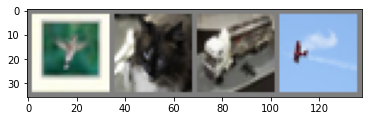

 bird -   cat - truck - plane


In [6]:
# Just visualising some images
def visualise_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch: training dataset
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('One batch - training dataset:', images.shape)

print('\nEach image of the batch:')
for i in range(labels.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, images[i].shape, labels[i]))
  if i == (labels.shape[0]-1):
    print('The "image" itself: ', images[i])

# Show images
visualise_images(torchvision.utils.make_grid(images))
# Print labels
print(' - '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## **Neural networks**

----

We use two neural networks in order to compare their performances based on the accuracy of the test dataset. The first network is ```CNN3L``` which is considered a shallow neural network (SNN) because it has two hidden (convolutional) layers and the output layer (traditionally, a model/network is considered shallow when it has one or two hidden layers).

<br>

The second network is the classical <a href="https://ieeexplore.ieee.org/document/726791">```LeNet-5```</a> DNN with five layers where four are hidden ones.



In [7]:
class CNN3L(nn.Module):
    def __init__(self, num_clas):
        super(CNN3L, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # Fully-connected layer
        self.out = nn.Linear(32 * 5 * 5, num_clas)
    def forward(self, x):
        #print('x size 0: ', x.size())
        x = self.conv1(x)
        #print('x size 1: ', x.size())
        x = self.conv2(x)
        #print('x size 2: ', x.size())
        x = x.view(x.size(0), -1) 
        #print('x size 3: ', x.size())
        output = self.out(x)
        #print('output: ', output.size())
        return output   

In [8]:
class LeNet5(nn.Module):
    def __init__(self, num_clas):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_clas)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## **Select the model**

----

Now, we can select one of the models/networks to train and evaluate.



In [9]:
opt = input("Enter your choice:")
if opt =='1':
  net = CNN3L(num_classes)
  opt_name = 'CNN3L'
  print("You selected CNN3L!")
elif opt =='2':
  net = LeNet5(num_classes)
  opt_name = 'LeNet-5'
  print("You selected LeNet-5!")
else:
  print("Invalid Option!")

if torch.cuda.is_available():
   net.to(device)

Enter your choice:2
You selected LeNet-5!


## **Define loss function and optimiser**

----

The <a href="https://github.com/AvivSham/Pytorch-MNIST-colab">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. The learning rate has already been defined.

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total trainable params: 62006
Checking trainable parameters: 62006


## **Training phase**

----

Now, we can train the model.



In [11]:
train_losses = []
train_acc = []
train_time_init = time.time()
for epoch in range(num_epochs):
  net.train() 
  running_loss = 0.0
  running_corrects = 0
  for images,labels in trainloader: # Iterate over data: begin
    images = Variable(images).to(device) # Send to GPU
    labels = Variable(labels).to(device) # Send to GPU
    
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data)
  # Iterate over data: end

  epoch_loss = running_loss / len(trainset)
  epoch_acc = running_corrects.double() / len(trainset)  
  print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.4f'
                 %(epoch+1, num_epochs, epoch_loss, epoch_acc))
  
  train_losses.append(epoch_loss)
  train_acc.append(epoch_acc) 

train_time_end = time.time() - train_time_init     

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Loss: 1.5284, Accuracy: 0.4380
Epoch [2/10], Loss: 1.2556, Accuracy: 0.5520
Epoch [3/10], Loss: 1.1571, Accuracy: 0.5917
Epoch [4/10], Loss: 1.0927, Accuracy: 0.6160
Epoch [5/10], Loss: 1.0529, Accuracy: 0.6300
Epoch [6/10], Loss: 1.0197, Accuracy: 0.6411
Epoch [7/10], Loss: 0.9992, Accuracy: 0.6484
Epoch [8/10], Loss: 0.9655, Accuracy: 0.6589
Epoch [9/10], Loss: 0.9495, Accuracy: 0.6648
Epoch [10/10], Loss: 0.9317, Accuracy: 0.6731


## **Save the best model**
----

You can save your best model to use later in the inference phase (here it is truly the model after the last epoch). 



In [12]:
best = './cifar10_net.pt'
torch.save(net.state_dict(), best)

## **Training phase: results**
----

Just showing the loss and accuracy during the training phase.

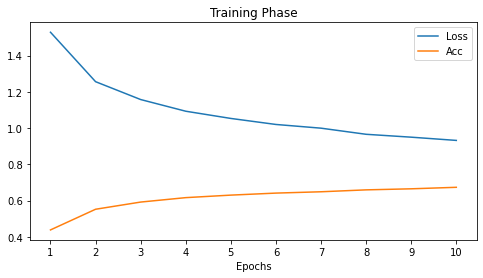

In [13]:
x = range(1,len(train_losses)+1)

plt.figure(figsize=(8,4))
plt.title("Training Phase")
plt.plot(x,train_losses,label="Loss")
plt.plot(x,train_acc,label="Acc")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## **Looking at the test dataset**

----

Just taking a quick look at the test dataset.



One batch - test dataset: torch.Size([4, 3, 32, 32])


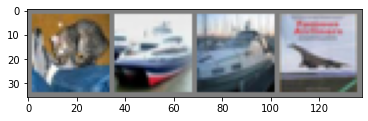

  cat -  ship -  ship - plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('One batch - test dataset:', images.shape)

# Show some images
visualise_images(torchvision.utils.make_grid(images))
# Print labels
print(' - '.join('%5s' % classes[labels[j]] for j in range(4)))

## **Load the model**
----

You can load your best model to use in the inference phase. 



In [15]:
if opt =='1':
  net = CNN3L(num_classes)
  print("Best CNN3L model loaded!")
elif opt =='2':
  net = LeNet5(num_classes)
  print("Best LeNet-5 model loaded!")
else:
  print("Invalid Option!")

if torch.cuda.is_available():
   net.to(device)
net.load_state_dict(torch.load(best))

Best LeNet-5 model loaded!


<All keys matched successfully>

## **Inference phase**

----

In the inference phase, we measure the performance of our model. 



In [16]:
am_training = net.training
print('Am I training? ', am_training)
net.eval()
am_training = net.training
print('Am I training? ', am_training)
inference_loss = 0.0
inference_corrects = 0

infer_time_init = time.time()
with torch.no_grad():
  for images,labels in testloader: # Iterate over data: begin
      images = Variable(images).to(device) # Send to GPU
      labels = labels.to(device) # Send to GPU

      outputs_infer = net(images)
      _, preds_infer = torch.max(outputs_infer,1)
      loss_infer = loss_function(outputs_infer, labels)

      inference_loss += loss_infer.item() * images.size(0)
      inference_corrects += torch.sum(preds_infer == labels.data)
  # Iterate over data: end

final_inference_loss = inference_loss / len(testset)
final_inference_acc = inference_corrects.double() / len(testset)

infer_time_end = time.time() - infer_time_init
print('\nTraining and inference in {:.0f}m {:.0f}s  OR  {:.0f}s'.format(
        (train_time_end + infer_time_end) // 60, 
        (train_time_end + infer_time_end) % 60,
         train_time_end + infer_time_end))

print('\nLoss of {}: {:.4f}'.format(opt_name, final_inference_loss))
print()
print('Accuracy of {}: {:.4f}'.format(opt_name, final_inference_acc))

Am I training?  True
Am I training?  False

Training and inference in 15m 32s  OR  932s

Loss of LeNet-5: 1.1210

Accuracy of LeNet-5: 0.6227
